# Model evaluation

In [1]:
import os
import time
import random
import pickle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import cv2

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
DATASET_PATH = '../dataset'
CSV_PATH = '../'
MODELS_PATH = '../models/'
MODEL_NAME = 'bs_xception_model_gb'
REPORTS_PATH = '../reports/'

In [3]:
label_df = pd.read_csv(os.path.join(CSV_PATH, 'bs_labels.csv'))
label_df.head(10)

,file_path,file_name,label,subset
0,wasp/1331787019_ca513a7acf_n.jpg,1331787019_ca513a7acf_n.jpg,wasp,train
1,bee/14322267704_2ac34a2af2_n.jpg,14322267704_2ac34a2af2_n.jpg,bee,train
2,wasp/7382817412_b5a0f8c899_w.jpg,7382817412_b5a0f8c899_w.jpg,wasp,train
3,wasp/4250759545_eb707b1145_n.jpg,4250759545_eb707b1145_n.jpg,wasp,train
4,other_insect/insect3.jpg,insect3.jpg,other_insect,train
5,other_insect/insect_image_204.jpg,insect_image_204.jpg,other_insect,train
6,other_insect/8542836797_477176edca_n.jpg,8542836797_477176edca_n.jpg,other_insect,train
7,bee/1324904081_75fdbb7ace_n.jpg,1324904081_75fdbb7ace_n.jpg,bee,train
8,bee/15063164899_4b3d4e7082_w.jpg,15063164899_4b3d4e7082_w.jpg,bee,train
9,wasp/6103665305_b52694b9a9_m.jpg,6103665305_b52694b9a9_m.jpg,wasp,train


## Model training history

In [4]:
model_history = pickle.load(open(MODELS_PATH + MODEL_NAME + '_hist', 'rb'))

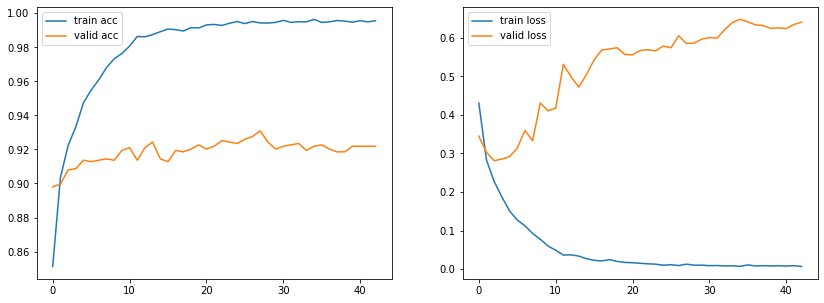

In [5]:
acc = model_history['accuracy']
val_acc = model_history['val_accuracy']

loss = model_history['loss']
val_loss = model_history['val_loss']

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='train acc')
plt.plot(val_acc, label='valid acc')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='train loss')
plt.plot(val_loss, label='valid loss')
plt.legend();

## Preprocess test data

In [6]:
NUM_CLASSES = 4
TARGET_SIZE = (299, 299)
BATCH_SIZE = 64

In [7]:
test_df = label_df[label_df['subset'] == 'test']

In [8]:
def gaussian_blur(img):
    return cv2.GaussianBlur(img, (5, 5), 0)

In [9]:
test_datagen = ImageDataGenerator(rescale=1. / 255,
                                  preprocessing_function=gaussian_blur)

test_generator = test_datagen.flow_from_dataframe(test_df,
                                                  directory=DATASET_PATH,
                                                  x_col='file_path',
                                                  y_col='label',
                                                  class_mode='categorical',
                                                  target_size=TARGET_SIZE,
                                                  shuffle=False,
                                                  batch_size=BATCH_SIZE)

Found 1266 validated image filenames belonging to 4 classes.


## Evaluate model

In [10]:
model = load_model(MODELS_PATH + MODEL_NAME + '.h5')

In [11]:
start_time = time.time()
test_loss, test_acc = model.evaluate(test_generator,
                                     steps=test_generator.n // BATCH_SIZE,
                                     verbose=2)
print("Test accuracy:", test_acc)
ej_time = time.time() - start_time
print(f'--- {ej_time} seconds ---')

19/19 - 158s - loss: 0.5415 - accuracy: 0.9293
Test accuracy: 0.9292762875556946
--- 158.6869707107544 seconds ---


In [12]:
time_by_batch = ej_time / (test_generator.n // BATCH_SIZE)
time_by_batch

8.35194582688181

In [13]:
# Get predictions from test set
predictions = model.predict(test_generator)
top_score = np.argmax(predictions, axis=1)

# Calculate confusion matrix
matrix = confusion_matrix(test_generator.classes, top_score)

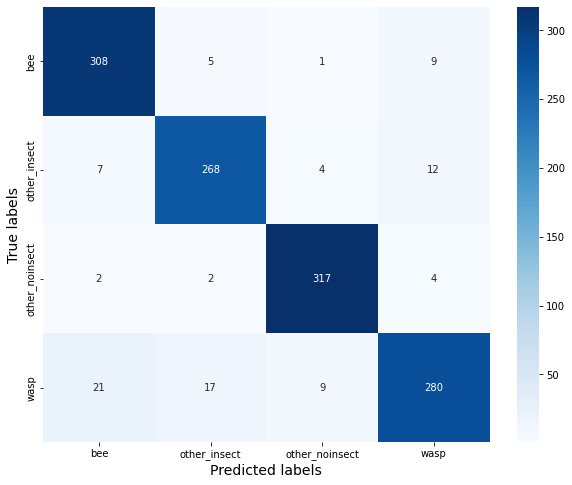

In [14]:
# Show confusion matrix
plt.figure(figsize=(10, 8))
class_labels = ['bee', 'other_insect', 'other_noinsect', 'wasp']
df_cm = pd.DataFrame(matrix, index=class_labels, columns=class_labels)
plt.yticks(va="center")
sns.heatmap(df_cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels', fontsize=14)
plt.ylabel('True labels', fontsize=14);

In [15]:
# Show classification report
print(classification_report(test_generator.classes,
                            top_score,
                            target_names=class_labels))

                precision    recall  f1-score   support

           bee       0.91      0.95      0.93       323
  other_insect       0.92      0.92      0.92       291
other_noinsect       0.96      0.98      0.97       325
          wasp       0.92      0.86      0.89       327

      accuracy                           0.93      1266
     macro avg       0.93      0.93      0.93      1266
  weighted avg       0.93      0.93      0.93      1266



In [16]:
# Export evaluation report
report_dict = classification_report(test_generator.classes,
                                    top_score,
                                    target_names=class_labels,
                                    output_dict=True)
df_r = pd.DataFrame(report_dict).transpose().reset_index()
df_r['ej_time'] = time_by_batch
df_r.to_csv(REPORTS_PATH + MODEL_NAME + '_report.csv', index=False)

## Review classification errors

In [17]:
df_results = pd.DataFrame({
    'image': test_generator.filenames,
    'true_label': test_generator.classes,
    'pred_label': top_score
})

In [18]:
df_errors = df_results[df_results['true_label'] != df_results['pred_label']]
df_errors.reset_index(drop=True, inplace=True)
df_errors.head()

,image,true_label,pred_label
0,bee/bee_image_496.jpg,0,3
1,bee/43112406195_45f6376096_n.jpg,0,3
2,bee/34001199640_96641168a1_n.jpg,0,3
3,wasp/74427231_eb108c7dc8_n.jpg,3,0
4,wasp/2570683320_1f738571a6_m.jpg,3,2


In [19]:
df_errors.shape

(93, 3)

In [20]:
df_errors.to_csv(REPORTS_PATH + MODEL_NAME + '_errors.csv', index=False)

../dataset/bee/bee_image_496.jpg
../dataset/bee/43112406195_45f6376096_n.jpg
../dataset/bee/34001199640_96641168a1_n.jpg
../dataset/wasp/74427231_eb108c7dc8_n.jpg


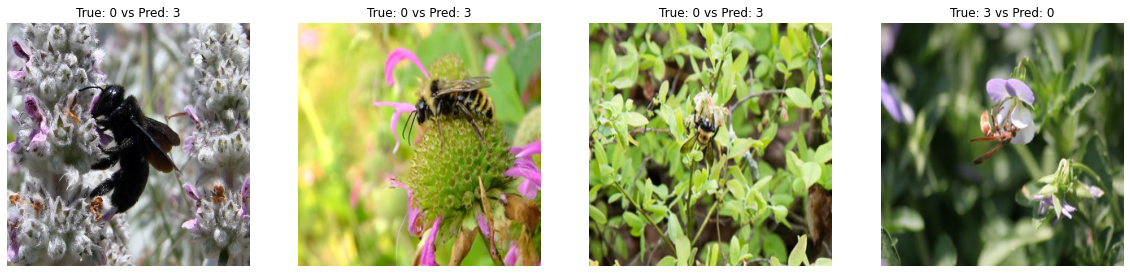

In [21]:
fig, axs = plt.subplots(1, 4, figsize=(20, 10))

for i, index in enumerate(range(0, 4)):
    img_path = DATASET_PATH + '/' + df_errors.iloc[index]['image']
    print(img_path)
    img = cv2.imread(img_path)
    img = cv2.resize(img, TARGET_SIZE)
    img_t = np.expand_dims(img / 255, axis=0)
    true_label = df_errors.iloc[index]['true_label']
    pred_label = df_errors.iloc[index]['pred_label']
    axs[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[i].set_title(f'True: {true_label} vs Pred: {pred_label}')
    axs[i].axis('off')

## Make predictions

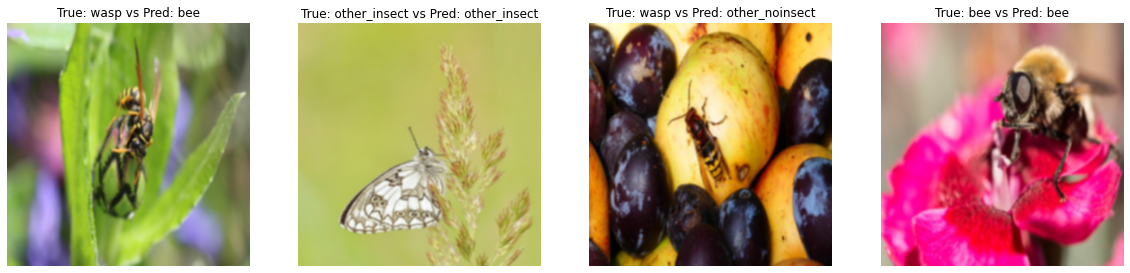

In [22]:
labels = {
    0: 'bee', 1: 'other_insect', 2: 'other_noinsect', 3: 'wasp'
}

fig, axs = plt.subplots(1, 4, figsize=(20, 10))

for i, index in enumerate(random.sample(range(0, len(test_df)), 4)):
    img = cv2.imread(DATASET_PATH  + '/' + test_df.iloc[index]['file_path'])
    img = cv2.resize(img, TARGET_SIZE)
    img = cv2.GaussianBlur(img, (5, 5), 0)
    img_t = np.expand_dims(img / 255, axis=0)
    preds = np.argmax(model.predict(img_t), axis=1)
    true_label = test_df.iloc[index]['label']
    axs[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[i].set_title(f'True: {true_label} vs Pred: {labels[preds[0]]}')
    axs[i].axis('off')

In [23]:
IMG_PATH = '/Users/elle/Downloads/hornet.jpg'
img = cv2.imread(IMG_PATH)
img = cv2.resize(img, TARGET_SIZE)
img = cv2.GaussianBlur(img, (5, 5), 0)
img_t = np.expand_dims(img / 255, axis=0)

In [24]:
np.argmax(model.predict(img_t), axis=1)

array([3])

In [25]:
# 0 - bee
# 1 - other insect
# 2 - other
# 3 - wasp

# Grad-CAM

In [26]:
def make_gradcam_heatmap(img_array,
                         model,
                         last_conv_layer_name,
                         pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output])

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [27]:
def cam(img_path, model, layer):
    # Import original image
    img_o = cv2.imread(img_path)
    img_o = cv2.resize(img_o, TARGET_SIZE)
    img_o = cv2.cvtColor(img_o, cv2.COLOR_BGR2RGB)
    img_o = cv2.GaussianBlur(img_o, (5, 5), 0)
    img_c = img_o.copy()

    # Create heatmap
    img_t = np.expand_dims(img_c / 255, axis=0)
    heatmap = make_gradcam_heatmap(img_t, model, layer)
    heatmap = np.uint8(255 * heatmap)

    # Asign color map to heatmap
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create RGB image from heatmap
    jet_heatmap = cv2.resize(jet_heatmap, TARGET_SIZE)
    jet_heatmap = np.uint8(jet_heatmap * 255)

    # Superimpose heatmap to original imag
    alpha = 0.4
    superimposed_img = cv2.addWeighted(jet_heatmap, alpha, img_o, 1 - alpha, 0)
    superimposed_img = np.uint8(superimposed_img)

    # Use heatmap to create bouncing box
    grey_img = cv2.cvtColor(jet_heatmap, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(grey_img, 127, 255, cv2.THRESH_BINARY)
    contours, hierarchy = cv2.findContours(thresh, 1, 2)

    for item in range(len(contours)):
        cnt = contours[item]
        x, y, w, h = cv2.boundingRect(cnt)

    # Add bouncing box to original image
    rectangle = cv2.rectangle(img_o,
                              pt1=(x, y),
                              pt2=(x + w, y + h),
                              color=(255, 0, 0),
                              thickness=2)

    # Create plot
    titles = [
        'Original image', 'Heatmap', 'Superimposed image', 'Rectangle image'
    ]
    image_type = [img_c, jet_heatmap, superimposed_img, rectangle]

    fig, axs = plt.subplots(1, 4, figsize=(20, 5))

    for i in range(4):
        axs[i].imshow(image_type[i])
        axs[i].set_title(titles[i])
        axs[i].axis('off')

    pred = np.argmax(model.predict(img_t), axis=1)
    labels = {0: 'bee', 1: 'other_insect', 2: 'other_noinsect', 3: 'wasp'}
    pred_label = labels[pred[0]]
    true_label = os.path.basename(os.path.dirname(img_path))
    plt.suptitle(
        f'True label - {true_label} vs Predicted label - {pred_label}',
        fontsize=16)

In [28]:
model = load_model(MODELS_PATH + MODEL_NAME + '.h5')
model.layers[-1].activation = None

In [29]:
LAYER = 'block14_sepconv2_act'
TARGET_SIZE = (299, 299)

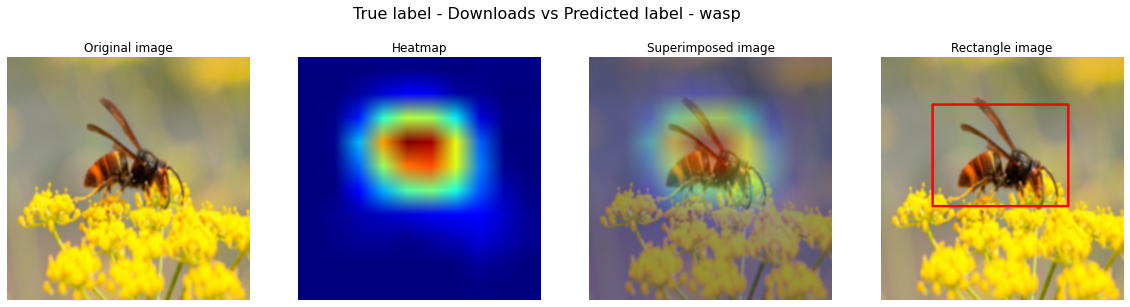

In [30]:
IMG_PATH = '/Users/elle/Downloads/3HDEQY2PJNBN3F65SZJ4JPB3V4.jpg'
cam(IMG_PATH, model, LAYER)